In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models

from imutils import paths
from pathlib import Path
import os
import time
import copy

import pandas as pd
import matplotlib.pylab as plt
import numpy as np

# Local modules
from train import train_model
from evaluation import make_predictions
from visualize import imshow, visualize_model
from utils import save_model_full, save_model_dict


pd.options.display.max_columns = 500
pd.options.display.max_rows = 500

In [2]:
def makeTransforms():
    # Data augmentation and normalization for training
    # Just normalization for validation
    data_transforms = {
        'train': transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'test': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }

    return data_transforms


In [3]:
# Script runtime options
root_dir = 'data'
data_dir = os.path.join(root_dir,'images')

In [4]:
# Get data transforms
data_transforms = makeTransforms()

In [5]:
# Setup data loaders with augmentation transforms
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

print('Number of data')
print('========================================')
for dataset in dataset_sizes.keys():
    print(dataset,' size:: ', dataset_sizes[dataset],' images')

print('')
print('Number of classes:: ', len(class_names))
print('========================================')
for i_class, class_name in enumerate(class_names):
    print(i_class,':: ',class_name)


Number of data
train  size::  5994  images
test  size::  5794  images

Number of classes::  200
0 ::  001.Black_footed_Albatross
1 ::  002.Laysan_Albatross
2 ::  003.Sooty_Albatross
3 ::  004.Groove_billed_Ani
4 ::  005.Crested_Auklet
5 ::  006.Least_Auklet
6 ::  007.Parakeet_Auklet
7 ::  008.Rhinoceros_Auklet
8 ::  009.Brewer_Blackbird
9 ::  010.Red_winged_Blackbird
10 ::  011.Rusty_Blackbird
11 ::  012.Yellow_headed_Blackbird
12 ::  013.Bobolink
13 ::  014.Indigo_Bunting
14 ::  015.Lazuli_Bunting
15 ::  016.Painted_Bunting
16 ::  017.Cardinal
17 ::  018.Spotted_Catbird
18 ::  019.Gray_Catbird
19 ::  020.Yellow_breasted_Chat
20 ::  021.Eastern_Towhee
21 ::  022.Chuck_will_Widow
22 ::  023.Brandt_Cormorant
23 ::  024.Red_faced_Cormorant
24 ::  025.Pelagic_Cormorant
25 ::  026.Bronzed_Cowbird
26 ::  027.Shiny_Cowbird
27 ::  028.Brown_Creeper
28 ::  029.American_Crow
29 ::  030.Fish_Crow
30 ::  031.Black_billed_Cuckoo
31 ::  032.Mangrove_Cuckoo
32 ::  033.Yellow_billed_Cuckoo
33 ::  034.

In [6]:
# Setup the device to run the computations
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device::', device)

Device:: cuda:0


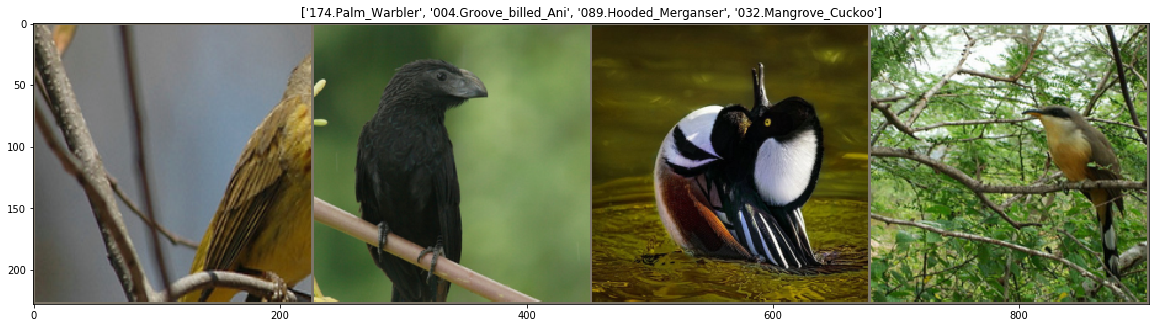

In [7]:
# Check the augmentations
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [8]:
# Setup the model and optimiser

model_ft = models.resnext101_32x8d(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_ft = train_model(model=model_ft, criterion=criterion, optimizer=optimizer_ft, scheduler=exp_lr_scheduler, 
                       device=device, dataloaders=dataloaders, dataset_sizes=dataset_sizes, num_epochs=40)

Epoch 0/39
----------
train Loss: 4.1875 Acc: 0.1170
test Loss: 1.9833 Acc: 0.4225

Epoch 1/39
----------
train Loss: 2.7247 Acc: 0.3320
test Loss: 1.6514 Acc: 0.5290

Epoch 2/39
----------
train Loss: 2.1805 Acc: 0.4466
test Loss: 1.3099 Acc: 0.6312

Epoch 3/39
----------
train Loss: 1.9081 Acc: 0.5128
test Loss: 1.3172 Acc: 0.6465

Epoch 4/39
----------
train Loss: 1.7388 Acc: 0.5522
test Loss: 1.1668 Acc: 0.7047

Epoch 5/39
----------
train Loss: 1.5947 Acc: 0.5874
test Loss: 1.3250 Acc: 0.6893

Epoch 6/39
----------
train Loss: 1.5009 Acc: 0.6190
test Loss: 1.2458 Acc: 0.7014

Epoch 7/39
----------
train Loss: 1.1025 Acc: 0.7274
test Loss: 0.8087 Acc: 0.7922

Epoch 8/39
----------
train Loss: 0.9152 Acc: 0.7753
test Loss: 0.7935 Acc: 0.7982

Epoch 9/39
----------
train Loss: 0.9191 Acc: 0.7808
test Loss: 0.7449 Acc: 0.8119

Epoch 10/39
----------
train Loss: 0.8785 Acc: 0.7875
test Loss: 0.7349 Acc: 0.8086

Epoch 11/39
----------
train Loss: 0.8192 Acc: 0.7936
test Loss: 0.7012 Acc

In [ ]:
save_model_full(model=model_ft, PATH='models/classification/caltech_birds_resnext101')

In [ ]:
visualize_model(model=model_ft, class_names=class_names, device=device)

# Load pre-trained model

In [ ]:
model_ = torch.load('models/classification/caltech_birds_resnext101_full.pth')
model_.eval()

In [ ]:
visualize_model(model=model_, class_names=class_names, device=device, dataloaders=dataloaders)

In [ ]:
was_training = model_.training
model_.eval()
images_so_far = 0


print('Commencing predictions minibatch..', end='')
with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['test']):
        if i % 25 == 0:
            print(i,'..', end='')

        inputs = inputs.to(device)
        labels = labels.to(device)
        

        outputs = model_(inputs)
        _, preds = torch.max(outputs, 1)

        if i == 0:
            labels_truth = labels.cpu().numpy()
            labels_pred = preds.cpu().numpy()
        else:
            labels_truth = np.concatenate((labels_truth,labels.cpu().numpy()))
            labels_pred = np.concatenate((labels_pred,preds.cpu().numpy()))

print('Complete.')


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix

In [ ]:
pd.DataFrame(classification_report(y_true=labels_truth, y_pred=labels_pred, target_names=class_names, output_dict=True))

In [ ]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_true=labels_truth, y_pred=labels_pred), index=class_names, columns=class_names)

In [ ]:
plt.figure(figsize=(40,40))
plt.imshow(confusion_matrix_df, cmap='Reds')
plt.xticks(np.arange(0,len(class_names),1), class_names, rotation=90)
plt.yticks(np.arange(0,len(class_names),1), class_names)
plt.colorbar()
plt.grid(True)
plt.show()